In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [ ]:
# ============================================================================
# Load Saved DataFrame from Pickle File
# ============================================================================

import pandas as pd

# Path to previously saved pickle file
PICKLE_PATH = "/content/drive/MyDrive/MSc Research/final_df.pkl"

# Load the DataFrame
df = pd.read_pickle(PICKLE_PATH)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188988 entries, 0 to 256135
Data columns (total 47 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   NCD_GRANTED_YEARS_B                188988 non-null  float64
 1   NCD_GRANTED_YEARS_C                188988 non-null  float64
 2   BEDROOMS                           188988 non-null  float64
 3   LEGAL_ADDON_PRE_REN                188988 non-null  int64  
 4   LEGAL_ADDON_POST_REN               188988 non-null  int64  
 5   HOME_EM_ADDON_PRE_REN              188988 non-null  int64  
 6   HOME_EM_ADDON_POST_REN             188988 non-null  int64  
 7   GARDEN_ADDON_PRE_REN               188988 non-null  int64  
 8   KEYCARE_ADDON_PRE_REN              188988 non-null  int64  
 9   KEYCARE_ADDON_POST_REN             188988 non-null  int64  
 10  HP1_ADDON_PRE_REN                  188988 non-null  int64  
 11  HP1_ADDON_POST_REN                 188988 no

In [ ]:
# =============================================================================
# Subsampling
# =============================================================================
def stratified_subsample(data, frac=0.1, n_bins=10, random_state=42):
    if frac >= 1.0:
        return data.copy()
    tmp = data.copy()
    tmp["prem_bin"] = pd.qcut(tmp["PREMIUM"], q=n_bins, labels=False, duplicates="drop")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state)
    idx = next(splitter.split(tmp, tmp["prem_bin"]))[1]
    return tmp.iloc[idx].drop(columns=["prem_bin"])

In [ ]:
# --- Directory to save models ---
MODEL_DIR = r"C:\Users\ellio\Desktop\MSc Dissertation"

# Dummy stratified_subsample (replace with your own if needed)
def stratified_subsample(df, frac=1.0, random_state=42):
    return df.sample(frac=frac, random_state=random_state)

# --- Lasso tuning with alpha curves + joblib save ---
def tune_lasso_with_curves(data, fractions=[0.1,0.25,0.5,0.75,1.0], random_state=42):
    all_results = {}
    summary = []

    for f in fractions:
        sub = stratified_subsample(data, frac=f, random_state=random_state)
        X = sub.drop(columns=["PREMIUM"])
        y = sub["PREMIUM"]

        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=random_state)

        # Define alpha search space
        alphas = np.logspace(-5, 0, 50)
        model = LassoCV(alphas=alphas, cv=5, random_state=random_state, max_iter=10000)
        model.fit(X_tr, y_tr)

        # Save trained model with fraction label
        model_path = f"{MODEL_DIR}\\lasso_{int(f*100)}.joblib"
        joblib.dump(model, model_path)

        # Evaluate test set
        p = model.predict(X_te)
        summary.append({
            "Fraction": f,
            "Best Alpha": model.alpha_,
            "R2": r2_score(y_te, p),
            "MAE": mean_absolute_error(y_te, p),
            "RMSE": np.sqrt(mean_squared_error(y_te, p)),
            "MAPE": mean_absolute_percentage_error(y_te, p),
            "Saved Model": model_path
        })

        # Store mean CV error per alpha (for plotting)
        all_results[f] = (model.alphas_, model.mse_path_.mean(axis=1))

    return pd.DataFrame(summary), all_results

# --- Run tuning ---
lasso_summary, lasso_curves = tune_lasso_with_curves(df)

print("\n=== Lasso Hyperparameter Tuning Results ===")
print(lasso_summary.to_string(index=False, float_format="%.4f"))




=== Lasso Hyperparameter Tuning Results ===
 Fraction  Best Alpha     R2     MAE    RMSE   MAPE                                              Saved Model
   0.1000      0.0045 0.6801 38.6870 51.6424 0.2543  C:\Users\ellio\Desktop\MSc Dissertation\lasso_10.joblib
   0.2500      0.0072 0.6634 39.7504 53.4381 0.2652  C:\Users\ellio\Desktop\MSc Dissertation\lasso_25.joblib
   0.5000      0.0036 0.6628 40.0088 54.1505 0.2811  C:\Users\ellio\Desktop\MSc Dissertation\lasso_50.joblib
   0.7500      0.0036 0.6695 39.6825 53.2503 0.2644  C:\Users\ellio\Desktop\MSc Dissertation\lasso_75.joblib
   1.0000      0.0036 0.6660 39.7902 53.6947 0.2615 C:\Users\ellio\Desktop\MSc Dissertation\lasso_100.joblib


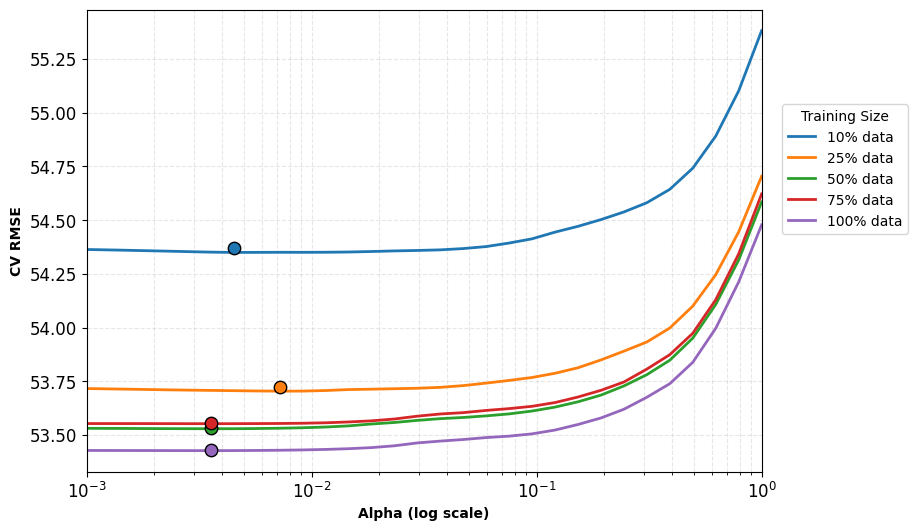

In [ ]:
# --- Plot RMSE vs Alpha curves (legend outside) ---
fig, ax = plt.subplots(figsize=(10,6))

for f, (alphas, mse) in lasso_curves.items():
    rmse = np.sqrt(mse)
    line, = ax.semilogx(alphas, rmse, label=f"{int(f*100)}% data", linewidth=2)

    # marker at best alpha (same color as line)
    best_alpha = lasso_summary.loc[lasso_summary["Fraction"] == f, "Best Alpha"].values[0]
    best_rmse = np.interp(best_alpha, alphas, rmse)
    ax.scatter(best_alpha, best_rmse, s=80, color=line.get_color(), edgecolor="black", zorder=5)

ax.set_xlim(1e-3, 1)
ax.set_xlabel("Alpha (log scale)", fontweight="bold")
ax.set_ylabel("CV RMSE", fontweight="bold")
#ax.set_title("Lasso RMSE vs Alpha across dataset sizes", fontweight="bold")

# Increase tick font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Legend outside (right)
leg = ax.legend(
    title="Training Size",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

# Make room on the right so the legend isn’t clipped
plt.subplots_adjust(right=0.80)
ax.grid(True, which="both", linestyle="--", alpha=0.3)

plt.show()


## **SHAP**

In [ ]:
import shap, joblib, pandas as pd, numpy as np, os, json

# --- Directory for SHAP outputs ---
EXPLAIN_DIR = "/content/drive/MyDrive/MSc Research/Lasso"
os.makedirs(EXPLAIN_DIR, exist_ok=True)

def explain_lasso(df, frac, model_path, out_dir=EXPLAIN_DIR):
    # 1) Load saved Lasso model
    model = joblib.load(model_path)

    # 2) Prepare the subsample
    sub = stratified_subsample(df, frac=frac, random_state=42)
    X = sub.drop(columns=["PREMIUM"])

    # 3) SHAP linear explainer
    explainer = shap.Explainer(model, X)  # LinearExplainer internally
    shap_exp = explainer(X)

    shap_values = shap_exp.values
    expected_value = shap_exp.base_values

    # 4) Save artefacts
    lab = str(int(frac*100))

    # raw SHAP values
    np.savez_compressed(f"{out_dir}/lasso_shap_values_{lab}.npz",
        shap_values=shap_values.astype(np.float32),
        feature_names=np.array(X.columns),
        expected_value=np.atleast_1d(expected_value).astype(np.float32)
    )

    # per-feature summary
    df_feat = pd.DataFrame({
        "feature": X.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0)
    }).sort_values("mean_abs_shap", ascending=False)
    df_feat["sample_label"], df_feat["sample_frac"] = lab, frac
    df_feat.to_csv(f"{out_dir}/lasso_mean_shap_{lab}.csv", index=False)

    # meta
    json.dump({"sample_label": lab, "frac": frac, "n_rows": len(X)},
              open(f"{out_dir}/lasso_shap_meta_{lab}.json", "w"))

    print(f"✅ Saved Lasso SHAP data for {lab}% sample")

# --- Run for all fractions ---
fractions = [0.10, 0.25, 0.50, 0.75, 1.00]
for f in fractions:
    model_path = f"/content/drive/MyDrive/MSc Research/Lasso/lasso_{int(f*100)}.joblib"
    explain_lasso(df, f, model_path)


✅ Saved Lasso SHAP data for 10% sample
✅ Saved Lasso SHAP data for 25% sample
✅ Saved Lasso SHAP data for 50% sample
✅ Saved Lasso SHAP data for 75% sample
✅ Saved Lasso SHAP data for 100% sample
